<a href="https://colab.research.google.com/github/ysw24neurorad/Acute-stroke_Detection_Segmentation/blob/main/site/ko/hub/tutorials/tf2_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운론드하기</a></td>
  <td><a href="https://tfhub.dev/tensorflow/collections/object_detection/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

# TensorFlow Hub 객체 감지 Colab

TensorFlow Hub 객체 감지 Colab에 오신 것을 환영합니다! 이 노트북에서는 이미지에서 "즉시 사용 가능한" 객체 감지 모델을 실행하는 단계를 안내합니다.

### 더 많은 모델

[이](https://tfhub.dev/tensorflow/collections/object_detection/1) 컬렉션에는 COCO 2017 데이터세트에서 훈련된 TF 2 객체 감지 모델이 포함되어 있습니다. 현재, [tfhub.dev](https://tfhub.dev/s?module-type=image-object-detection)에서 호스팅되는 모든 객체 감지 모델은 [여기](https://tfhub.dev/)에서 찾을 수 있습니다.

## 가져오기 및 설정

기본 가져오기부터 시작하겠습니다.

In [1]:
# This Colab requires a recent numpy version.
!pip install numpy==1.24.3
!pip install protobuf==3.20.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.0.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 2.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/chec

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## 유틸리티

다음 셀을 실행하여 나중에 필요한 일부 유틸리티를 만듭니다.

- 이미지를 로드하는 도우미 메서드
- 모델 이름과 TF Hub 핸들의 매핑
- COCO 2017 데이터세트에 대한 인간 키포인트가 있는 튜플 목록(키포인트가 있는 모델에 필요)

In [3]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## 시각화 도구

적절하게 감지된 상자, 키포인트 및 세분화로 이미지를 시각화하기 위해 TensorFlow Object Detection API를 사용합니다. 설치를 위해 리포지토리를 복제합니다.

In [4]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4305, done.
remote: Counting objects: 100% (4305/4305), done.
remote: Compressing objects: 100% (3324/3324), done.
remote: Total 4305 (delta 1208), reused 2104 (delta 908), pack-reused 0 (from 0)
Receiving objects: 100% (4305/4305), 53.17 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


Object Detection API 설치하기

In [1]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for object_detection: filename=object_detection-0.1-py3-none-any.whl size=1697356 sha256=41924a7b64d50b2531a9068b43910d3a01b2215c5bbed62361c957ea8630d80c
  Stored in directory: /tmp/pip-ephem-wheel-cache-osy2gi_c/wheels/95/4a/63/b2d36ca06eab841de19a38993ffaf2beac152a44539bc642a6
Successfully built object_detection
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: object_detection
    Found existing instal

이제 나중에 필요한 종속성을 가져올 수 있습니다.

In [3]:
!pip install --force-reinstall protobuf==4.25.2
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


### 플로팅을 위해 레이블 맵 데이터 로드하기

레이블 맵은 인덱스 번호를 범주 이름에 대응시키므로, 컨볼루션 네트워크가 `5`를 예측할 때 이것이 `airplane`에 해당한다는 것을 알 수 있습니다. 여기서는 내부 유틸리티 함수를 사용하지만, 정수를 적절한 문자열 레이블에 매핑하는 사전을 반환하는 함수라면 문제 없습니다.

간단히 하기 위해 Object Detection API 코드를 로드한 리포지토리에서 로드하겠습니다.

In [4]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 감지 모델을 빌드하고 사전 훈련된 모델 가중치 로드하기

여기서 사용할 객체 감지 모델을 선택합니다. 아키텍처를 선택하면 자동으로 로드됩니다. 나중에 다른 아키텍처를 시도하기 위해 모델을 변경하려면 다음 셀을 변경하고 이어지는 셀을 실행하세요.

**팁:** 선택한 모델에 대한 자세한 내용을 보려면 링크(모델 핸들)로 이동하여 TF Hub에 대한 추가 문서를 읽어보세요. 모델을 선택하면 더 쉽게 처리할 수 있도록 핸들이 출력됩니다.

In [7]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
# ... (rest of the dictionary)
}

In [8]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


## TensorFlow Hub에서 선택한 모델 로드하기

여기에서는 선택된 모델 핸들만 필요하고 Tensorflow Hub 라이브러리를 사용하여 이 핸들을 메모리에 로드합니다.


In [10]:
# Add this line at the beginning of your cell or your notebook.
import tensorflow_hub as hub

print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


model loaded!
loading model...


model loaded!


## 이미지 로드하기

간단한 이미지로 모델을 시도해 보겠습니다. 이를 위해 테스트 이미지 목록을 제공합니다.

궁금하다면 다음과 같이 간단한 시도를 해볼 수 있습니다.

- 자신의 이미지에서 추론을 실행해 봅니다. 이미지를 colab에 업로드하고 아래 셀에서 수행한 것과 같은 방식으로 로드합니다.
- 일부 입력 이미지를 수정하고 여전히 제대로 감지되는지 확인합니다. 여기에서 간단히 이미지를 수평으로 뒤집거나 회색조로 변환하는 몇 가지 간단한 작업을 시도해 볼 수 있습니다(입력 이미지에는 여전히 3개의 채널이 있어야 함).

**주의:** 알파 채널이 있는 이미지를 사용하는 경우, 모델은 3개 채널 이미지를 예상하고 알파는 4번째 채널로 계산됩니다.


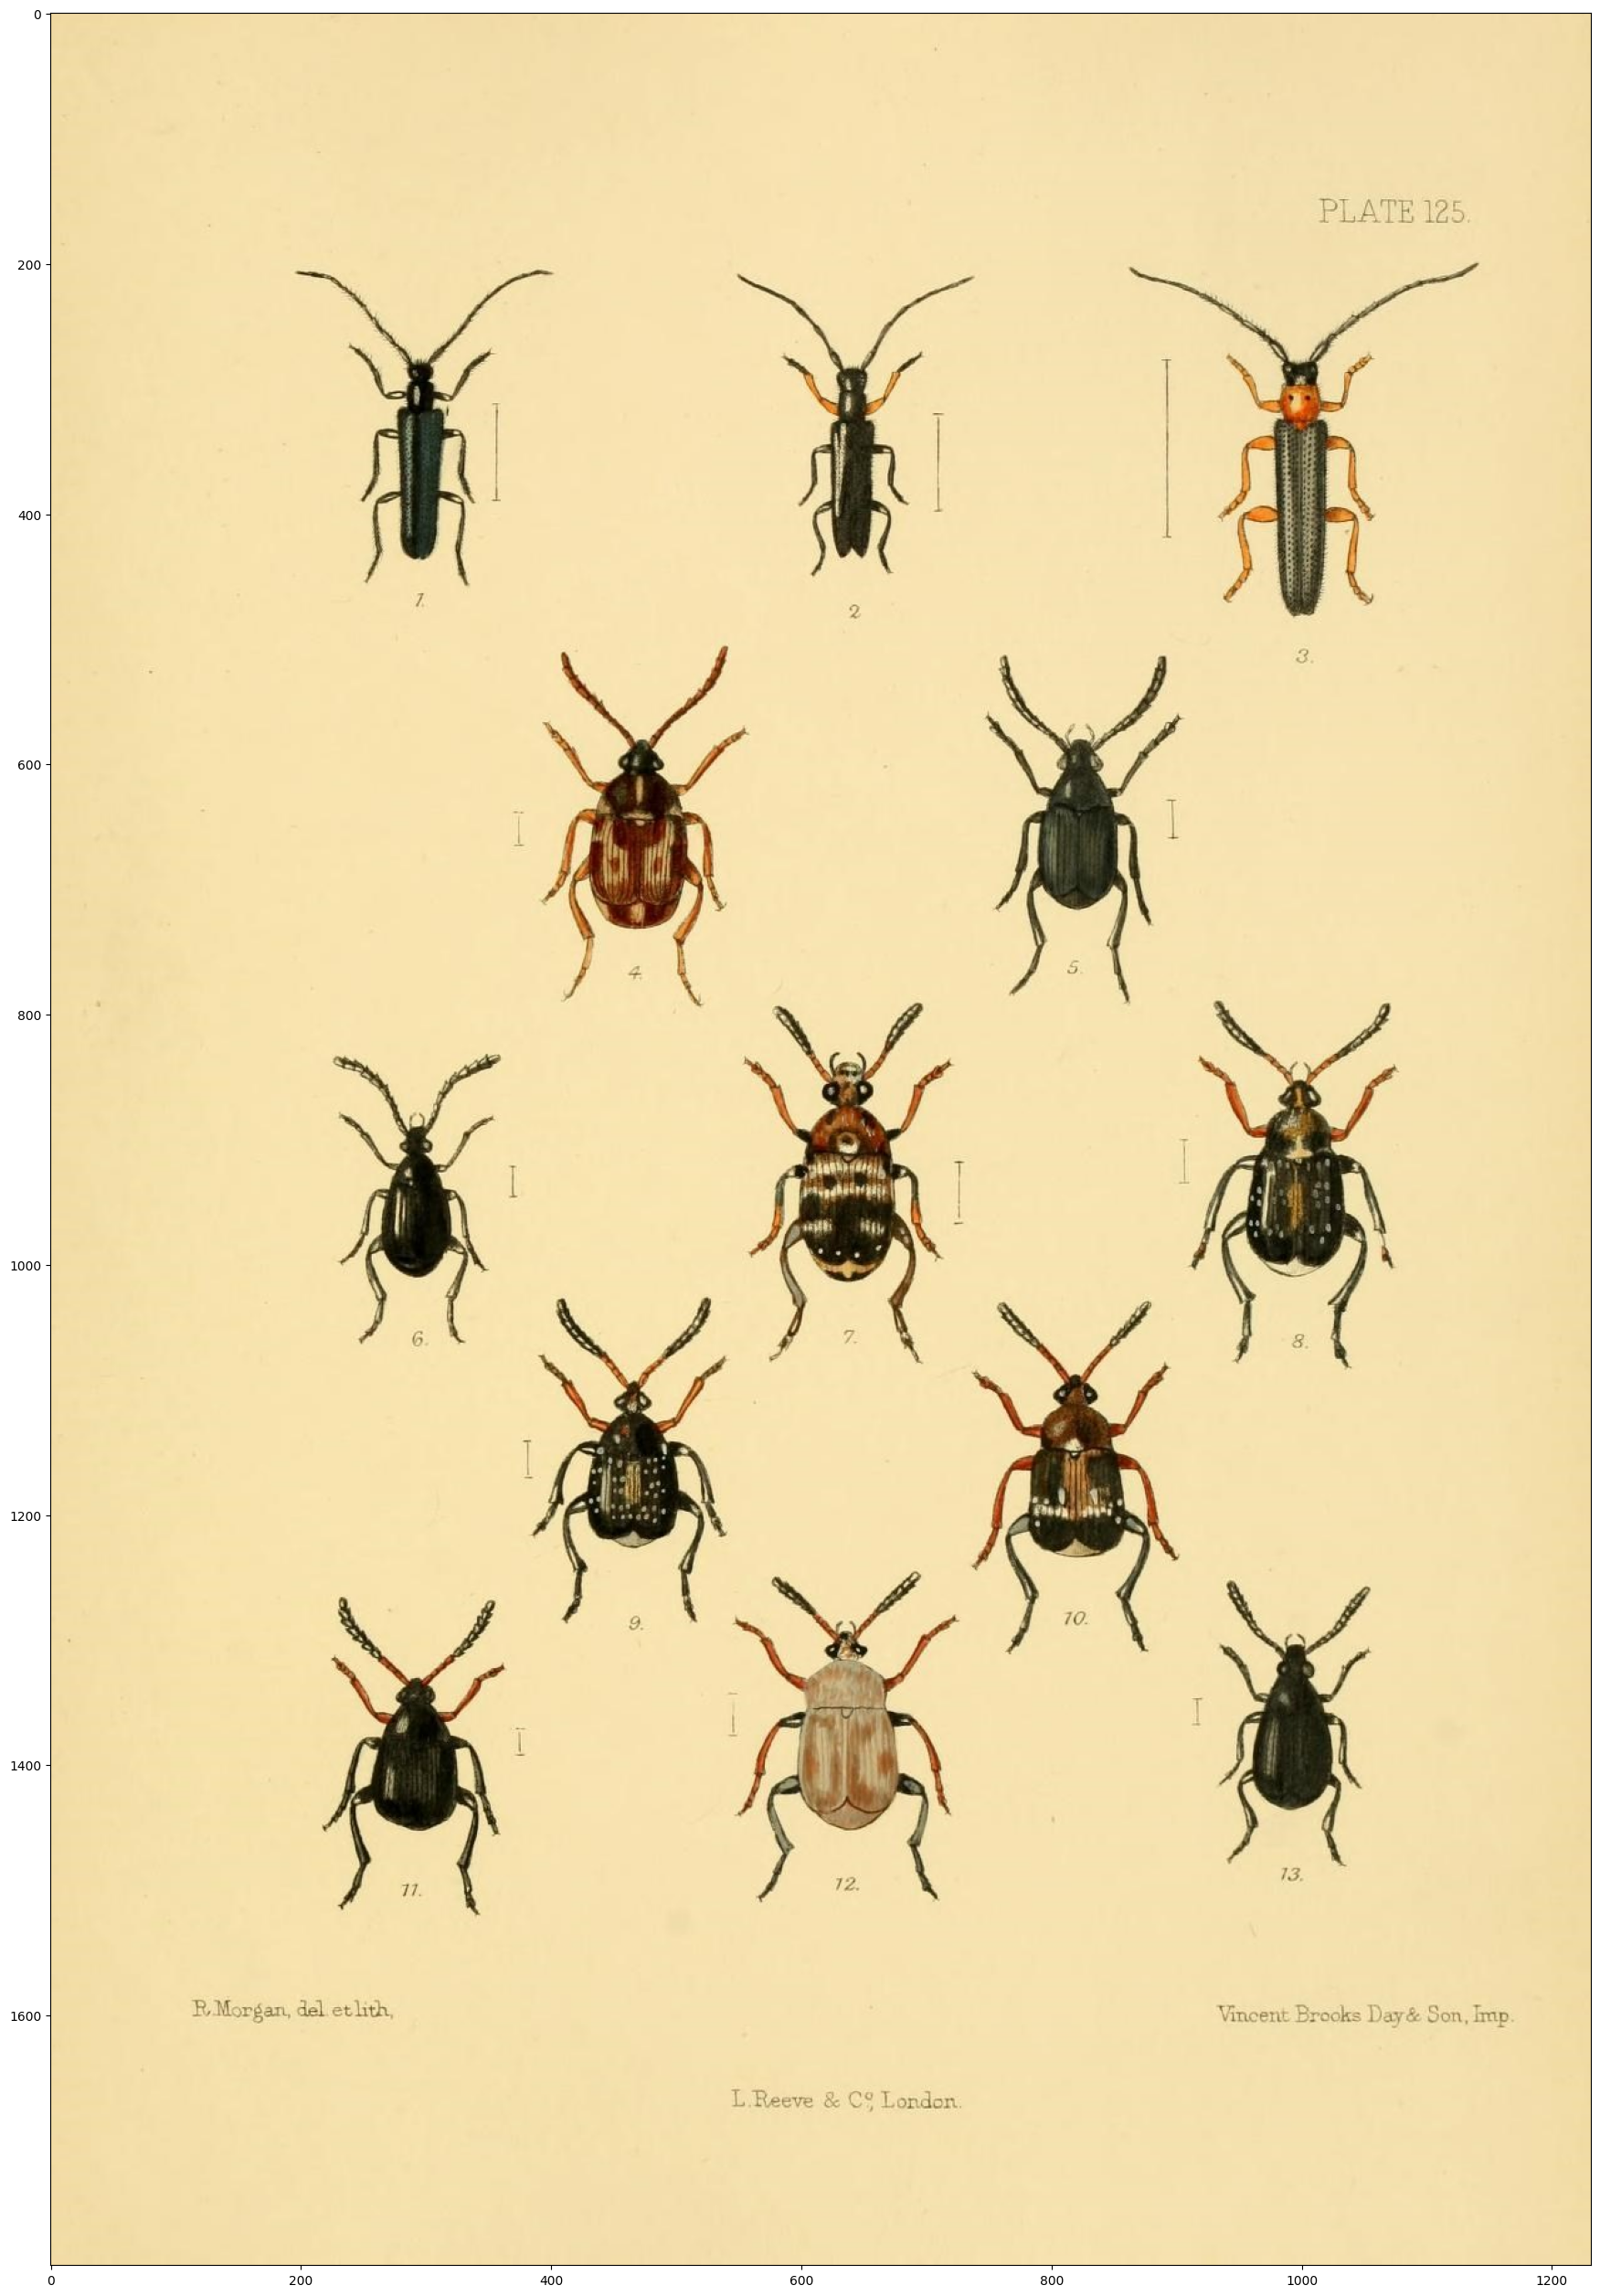

In [20]:
# Import the pyplot module from matplotlib and alias it as plt
import matplotlib.pyplot as plt

#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Beatles' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

# Define IMAGES_FOR_TEST within the current cell
IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

# Import TensorFlow
import tensorflow as tf

# Import BytesIO from io
from io import BytesIO
from six import BytesIO
from six.moves.urllib.request import urlopen


# Import numpy
import numpy as np  # This line imports numpy and assigns it to the alias 'np'

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  # Import Image from PIL within the function
  from PIL import Image

  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## 추론하기

추론을 수행하려면 TF Hub 로드 모델을 호출하기만 하면 됩니다.

시도해볼 수 있는 작업:

- `result['detection_boxes']`를 출력하고 상자 위치를 이미지의 상자와 일치시킵니다. 좌표는 정규화된 형식(예: [0, 1] 간격)으로 제공됩니다.
- 결과에 있는 다른 출력 키를 검사합니다. 모델 문서 페이지에서 전체 문서를 볼 수 있습니다(브라우저에서 앞서 출력된 모델 핸들을 가리킴).

In [25]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'detection_classes', 'detection_keypoint_scores', 'detection_keypoints', 'detection_scores', 'num_detections'])


## 결과 시각화하기

여기에서는 추론 단계의 사각형(및 가능한 경우 키포인트)을 표시하기 위해 TensorFlow Object Detection API가 필요합니다.

이 방법을 보여주는 전체 문서는 [여기](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)에서 확인할 수 있습니다.

예를 들어, 여기에서 `min_score_thresh`를 다른 값(0과 1 사이)으로 설정하여 더 많이 감지할 수 있게 하거나 더 많은 감지를 필터링할 수 있습니다.

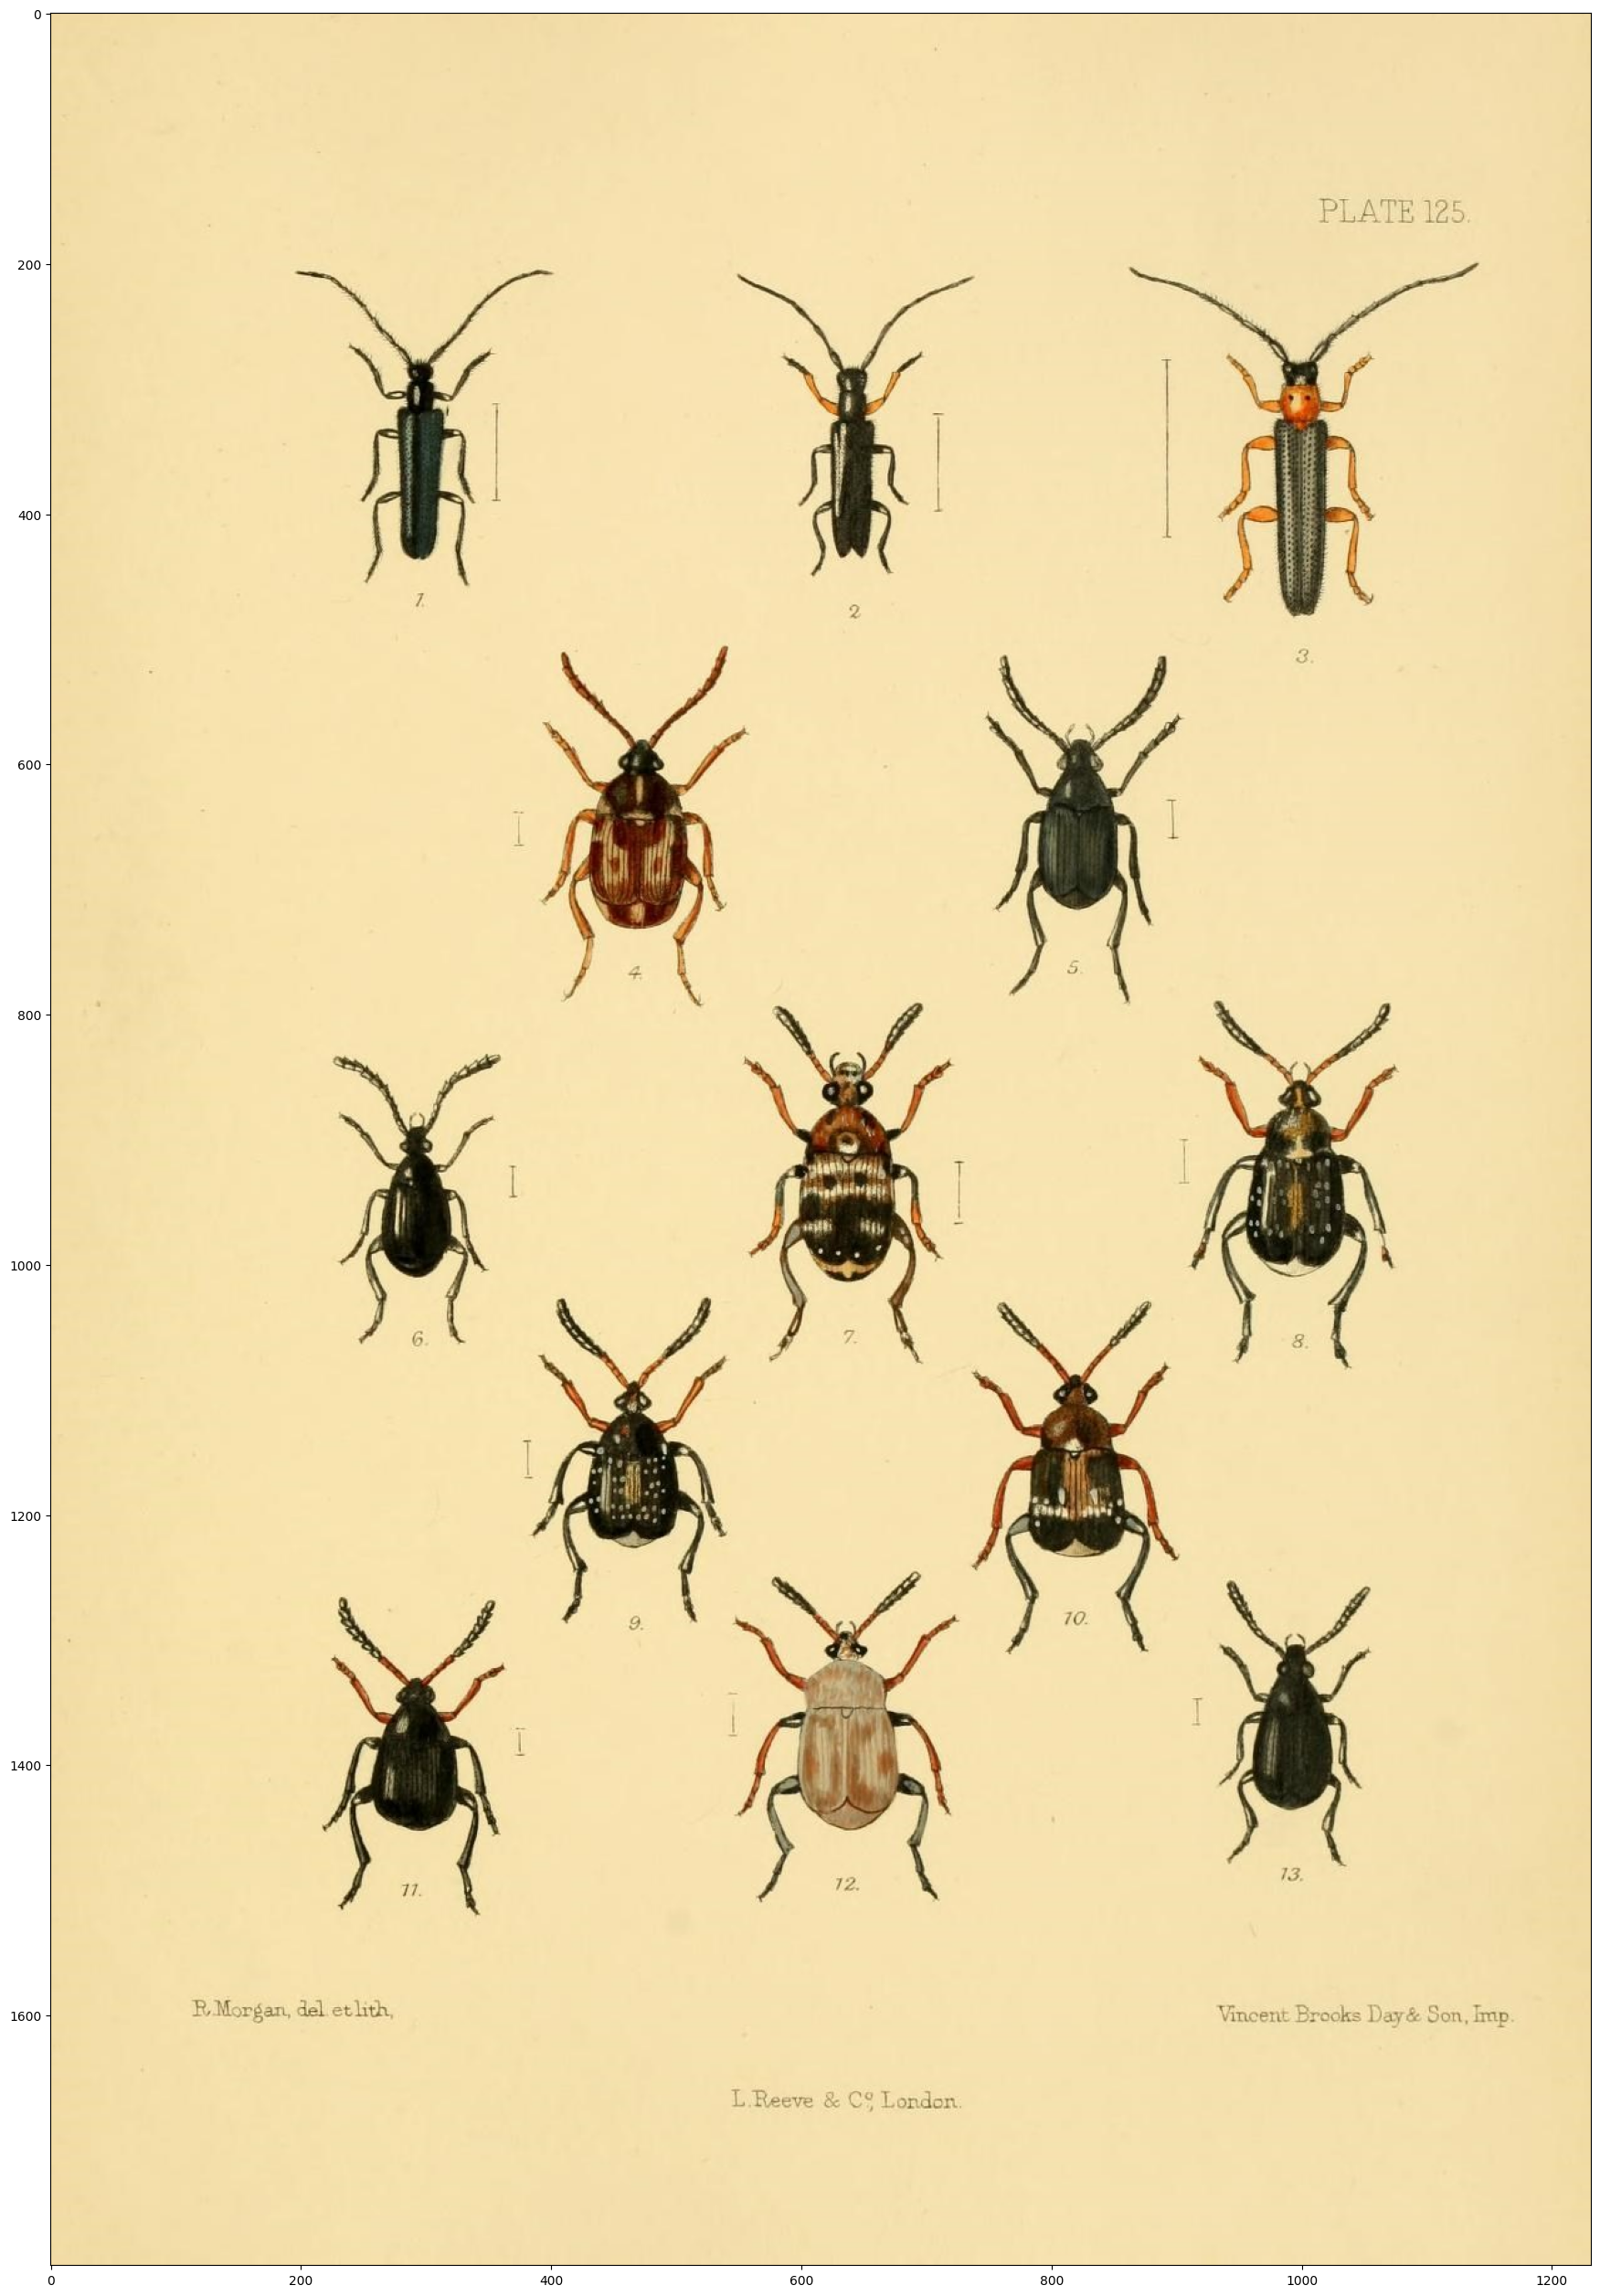

In [24]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]
# Define COCO17_HUMAN_POSE_KEYPOINTS here before it's used
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]


viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

## [옵션]

사용 가능한 객체 감지 모델 중에는 Mask R-CNN이 있으며, 이 모델의 출력은 인스턴스 분할을 허용합니다.

이를 시각화하기 위해 이전에 했던 것과 같은 방법을 사용하지만 다른 매개변수를 추가합니다. `instance_masks=output_dict.get('detection_masks_reframed', None)`


In [ ]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()